In [1]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf 
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Pandas 1.4.3
Scikit-Learn 1.1.1
GPU is available


In [2]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.2)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [3]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [4]:
def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.ResNet50V2(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [5]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'ResNet50V2.h5', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint

In [6]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [7]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [8]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    
def saveModel(model, className):
    model.save(className + " - ResNet50V2.h5")
    print("Model Saved!")

In [9]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [10]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [11]:
mpath = r'../AIDISS/Dataset/Multi Cancer'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 20
lr = 0.001

for i in classPaths:
    className = i
    print(className)

ALL
ALL_RAW
BreaKHis_Total_dataset_RAW
Breast Cancer
Lung and Colon Cancer
Lung_and_Colon_Cancer_RAW
Lymphoma
Oral Cancer



Total :  Found 3256 files belonging to 4 classes.

For Training :  Found 2607 images belonging to 4 classes.

For Val :  Found 649 images belonging to 4 classes.

No of Classes :  4
Classes :  ['Benign', 'Early', 'Pre', 'Pro']
Image Shape :  (32, 256, 256, 3)
94683136/94668760 [==============================] - 147s 2us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472      

82/82 [==============================] - 21s 151ms/step - loss: 693.4743 - accuracy: 0.5497 - val_loss: 577.5230 - val_accuracy: 0.4992

Epoch 00001: val_loss improved from inf to 577.52301, saving model to ALL_RAWResNet50V2.h5


C:\Users\alexj\anaconda3\envs\compvis\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
82/82 [==============================] - 8s 102ms/step - loss: 90.3277 - accuracy: 0.7733 - val_loss: 319.0281 - val_accuracy: 0.6641

Epoch 00002: val_loss improved from 577.52301 to 319.02811, saving model to ALL_RAWResNet50V2.h5
Epoch 3/20
82/82 [==============================] - 8s 101ms/step - loss: 104.7270 - accuracy: 0.7568 - val_loss: 291.4941 - val_accuracy: 0.7488

Epoch 00003: val_loss improved from 319.02811 to 291.49408, saving model to ALL_RAWResNet50V2.h5
Epoch 4/20
82/82 [==============================] - 8s 101ms/step - loss: 99.4935 - accuracy: 0.7856 - val_loss: 398.4370 - val_accuracy: 0.6256

Epoch 00004: val_loss did not improve from 291.49408
Epoch 5/20
82/82 [==============================] - 8s 101ms/step - loss: 53.1240 - accuracy: 0.8362 - val_loss: 204.0039 - val_accuracy: 0.6980

Epoch 00005: val_loss improved from 291.49408 to 204.00388, saving model to ALL_RAWResNet50V2.h5
Epoch 6/20
82/82 [==============================] - 8s 101ms/step - los

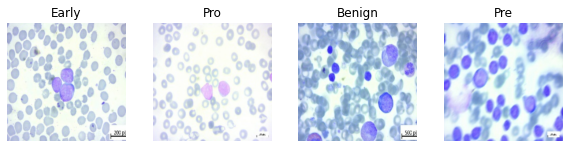

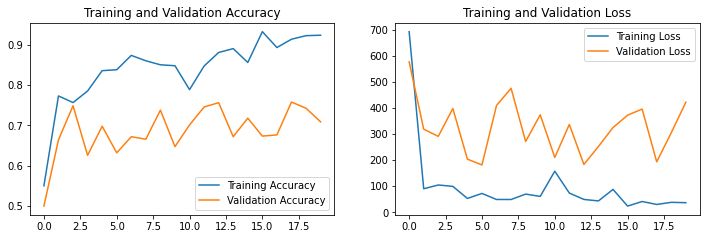

21/21 [==============================] - 2s 77ms/step - loss: 422.4167 - accuracy: 0.7088
Accuracy on the Test Set = 70.88 %
Model Saved!
True :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

<Figure size 432x288 with 0 Axes>

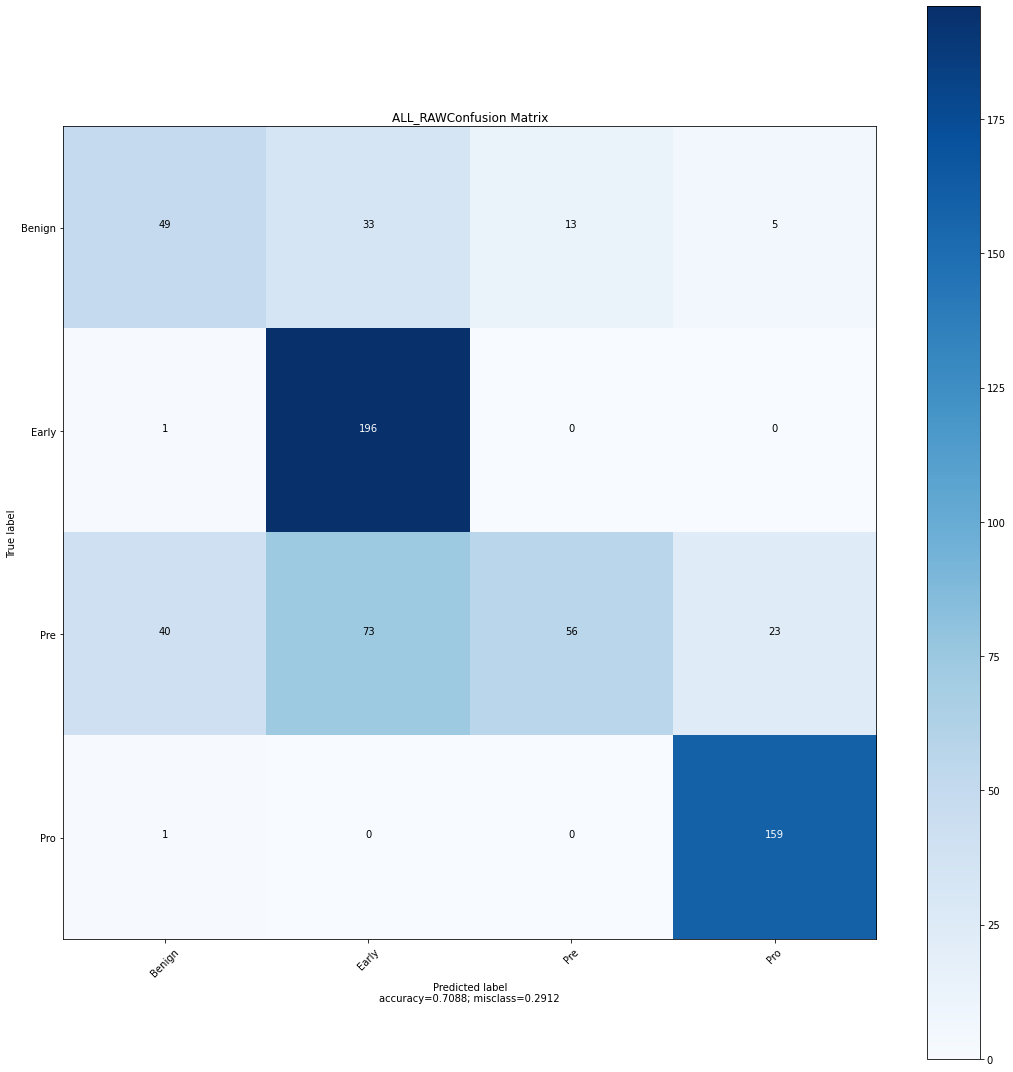

<Figure size 432x288 with 0 Axes>

In [12]:
className = 'ALL_RAW'
cpath = os.path.join(mpath, 'ALL_RAW')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 20000 files belonging to 4 classes.

For Training :  Found 16000 images belonging to 4 classes.

For Val :  Found 4000 images belonging to 4 classes.

No of Classes :  4
Classes :  ['all_benign', 'all_early', 'all_pre', 'all_pro']
Image Shape :  (32, 256, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________

500/500 [==============================] - 69s 133ms/step - loss: 263.7601 - accuracy: 0.6259 - val_loss: 314.3818 - val_accuracy: 0.6840

Epoch 00001: val_loss improved from inf to 314.38184, saving model to ALL ResNet50V2.h5


C:\Users\alexj\anaconda3\envs\compvis\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
500/500 [==============================] - 61s 123ms/step - loss: 114.0661 - accuracy: 0.7424 - val_loss: 35.5116 - val_accuracy: 0.8468

Epoch 00002: val_loss improved from 314.38184 to 35.51158, saving model to ALL ResNet50V2.h5
Epoch 3/20
500/500 [==============================] - 57s 114ms/step - loss: 80.8137 - accuracy: 0.7954 - val_loss: 199.7506 - val_accuracy: 0.6855

Epoch 00003: val_loss did not improve from 35.51158
Epoch 4/20
500/500 [==============================] - 54s 108ms/step - loss: 80.6811 - accuracy: 0.8204 - val_loss: 146.1623 - val_accuracy: 0.6398

Epoch 00004: val_loss did not improve from 35.51158
Epoch 5/20
500/500 [==============================] - 55s 110ms/step - loss: 100.9783 - accuracy: 0.8086 - val_loss: 198.4795 - val_accuracy: 0.7448

Epoch 00005: val_loss did not improve from 35.51158
Epoch 6/20
500/500 [==============================] - 58s 115ms/step - loss: 62.2149 - accuracy: 0.8659 - val_loss: 190.3735 - val_accuracy: 0.7790

Epoch

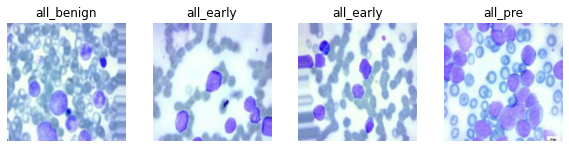

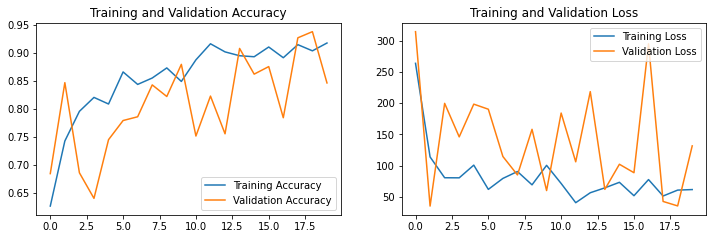

125/125 [==============================] - 11s 88ms/step - loss: 131.7664 - accuracy: 0.8462
Accuracy on the Test Set = 84.62 %
Model Saved!
True :  [0 0 0 ... 3 3 3]
Predicted :  [1 0 3 ... 3 3 3]


<Figure size 432x288 with 0 Axes>

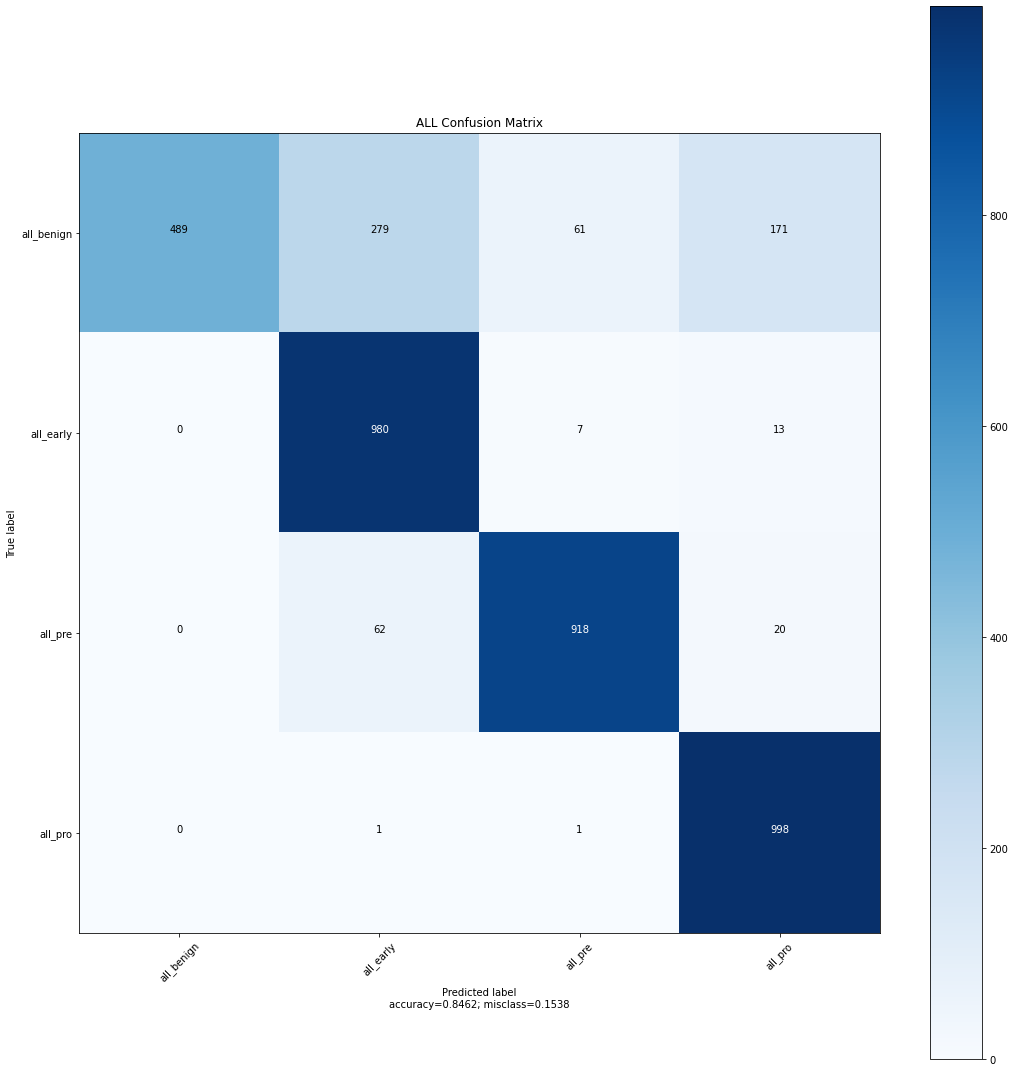

<Figure size 432x288 with 0 Axes>

In [13]:
className = 'ALL '
cpath = os.path.join(mpath, 'ALL')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=128)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 7783 files belonging to 2 classes.

For Training :  Found 6228 images belonging to 2 classes.

For Val :  Found 1555 images belonging to 2 classes.

No of Classes :  2
Classes :  ['benign', 'malignant']
Image Shape :  (32, 256, 256, 3)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
______________________________________

Epoch 1/20
195/195 [==============================] - 74s 372ms/step - loss: 279.4786 - accuracy: 0.6840 - val_loss: 144.0851 - val_accuracy: 0.6399

Epoch 00001: val_loss improved from inf to 144.08508, saving model to BreaKHis_Total_dataset_RAWResNet50V2.h5


C:\Users\alexj\anaconda3\envs\compvis\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
195/195 [==============================] - 69s 354ms/step - loss: 85.1555 - accuracy: 0.7685 - val_loss: 173.2804 - val_accuracy: 0.6129

Epoch 00002: val_loss did not improve from 144.08508
Epoch 3/20
195/195 [==============================] - 68s 349ms/step - loss: 82.5751 - accuracy: 0.7661 - val_loss: 67.3298 - val_accuracy: 0.7428

Epoch 00003: val_loss improved from 144.08508 to 67.32984, saving model to BreaKHis_Total_dataset_RAWResNet50V2.h5
Epoch 4/20
195/195 [==============================] - 70s 358ms/step - loss: 107.7473 - accuracy: 0.7662 - val_loss: 328.9453 - val_accuracy: 0.6849

Epoch 00004: val_loss did not improve from 67.32984
Epoch 5/20
195/195 [==============================] - 70s 357ms/step - loss: 138.6887 - accuracy: 0.7649 - val_loss: 167.1232 - val_accuracy: 0.7010

Epoch 00005: val_loss did not improve from 67.32984
Epoch 6/20
195/195 [==============================] - 71s 363ms/step - loss: 113.1244 - accuracy: 0.7881 - val_loss: 201.1254 - val

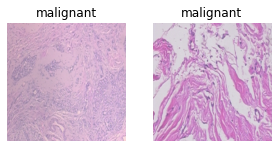

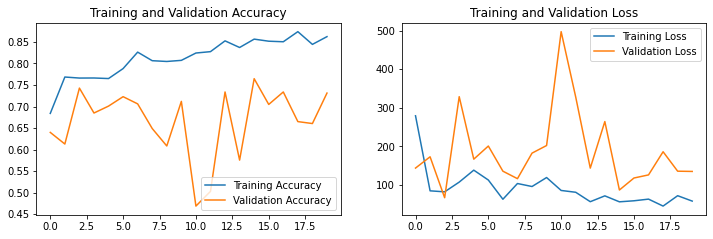

49/49 [==============================] - 12s 241ms/step - loss: 135.3836 - accuracy: 0.7312
Accuracy on the Test Set = 73.12 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

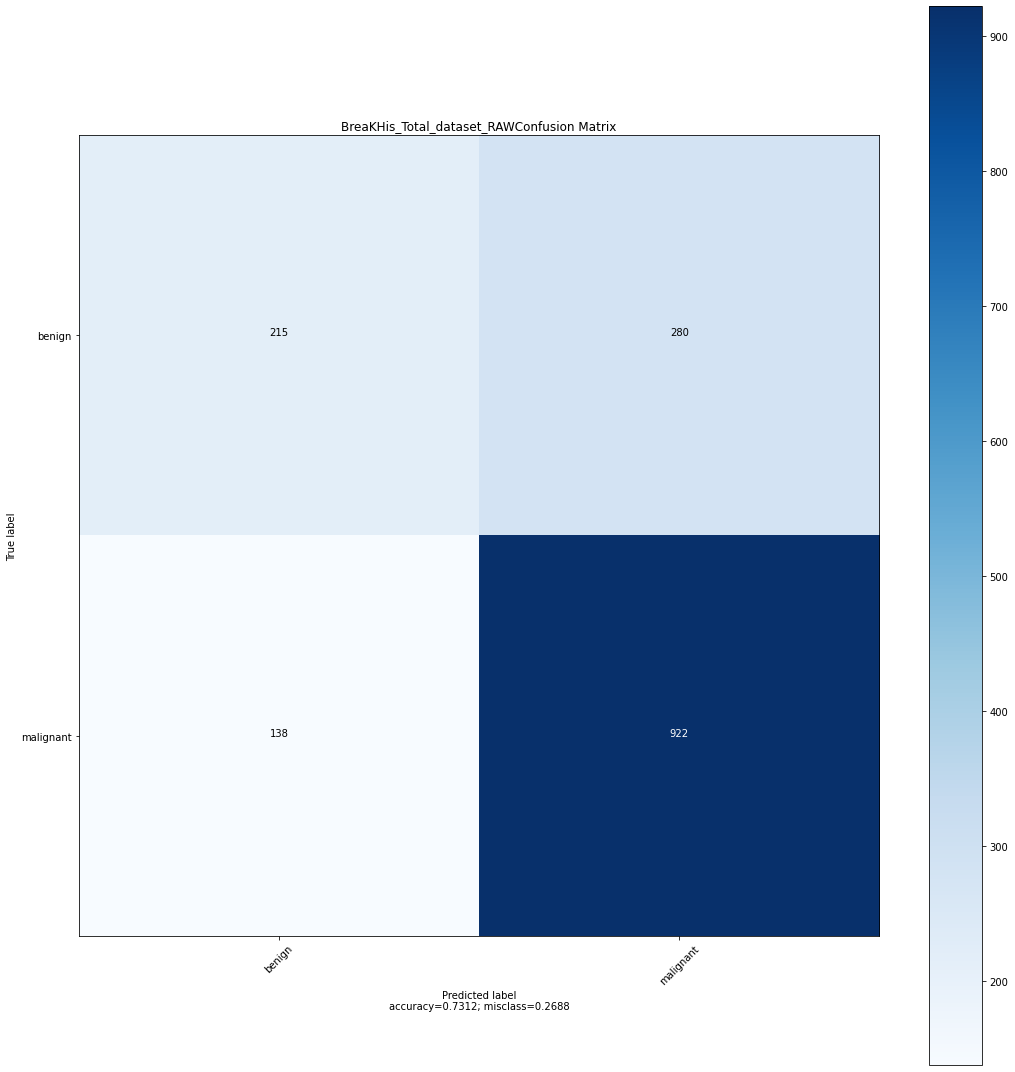

<Figure size 432x288 with 0 Axes>

In [14]:
className = 'BreaKHis_Total_dataset_RAW'
cpath = os.path.join(mpath, 'BreaKHis_Total_dataset_RAW')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 8000 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
_______________________

250/250 [==============================] - 43s 163ms/step - loss: 180.2872 - accuracy: 0.7770 - val_loss: 26.9747 - val_accuracy: 0.8915

Epoch 00001: val_loss improved from inf to 26.97468, saving model to Breast Cancer ResNet50V2.h5


C:\Users\alexj\anaconda3\envs\compvis\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
250/250 [==============================] - 41s 162ms/step - loss: 65.2946 - accuracy: 0.8406 - val_loss: 32.2722 - val_accuracy: 0.8890

Epoch 00002: val_loss did not improve from 26.97468
Epoch 3/20
250/250 [==============================] - 40s 160ms/step - loss: 51.6004 - accuracy: 0.8691 - val_loss: 169.9442 - val_accuracy: 0.7320

Epoch 00003: val_loss did not improve from 26.97468
Epoch 4/20
250/250 [==============================] - 40s 160ms/step - loss: 57.6019 - accuracy: 0.8727 - val_loss: 50.8165 - val_accuracy: 0.8845

Epoch 00004: val_loss did not improve from 26.97468
Epoch 5/20
250/250 [==============================] - 39s 158ms/step - loss: 63.0821 - accuracy: 0.8819 - val_loss: 268.5929 - val_accuracy: 0.7315

Epoch 00005: val_loss did not improve from 26.97468
Epoch 6/20
250/250 [==============================] - 40s 158ms/step - loss: 49.4712 - accuracy: 0.9026 - val_loss: 48.5445 - val_accuracy: 0.8820

Epoch 00006: val_loss did not improve from 26.9746

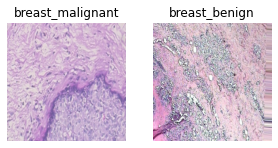

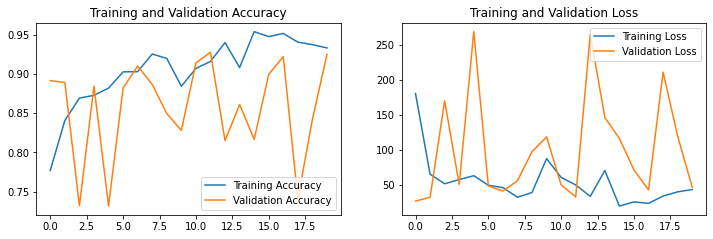

63/63 [==============================] - 8s 130ms/step - loss: 46.9394 - accuracy: 0.9250
Accuracy on the Test Set = 92.50 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

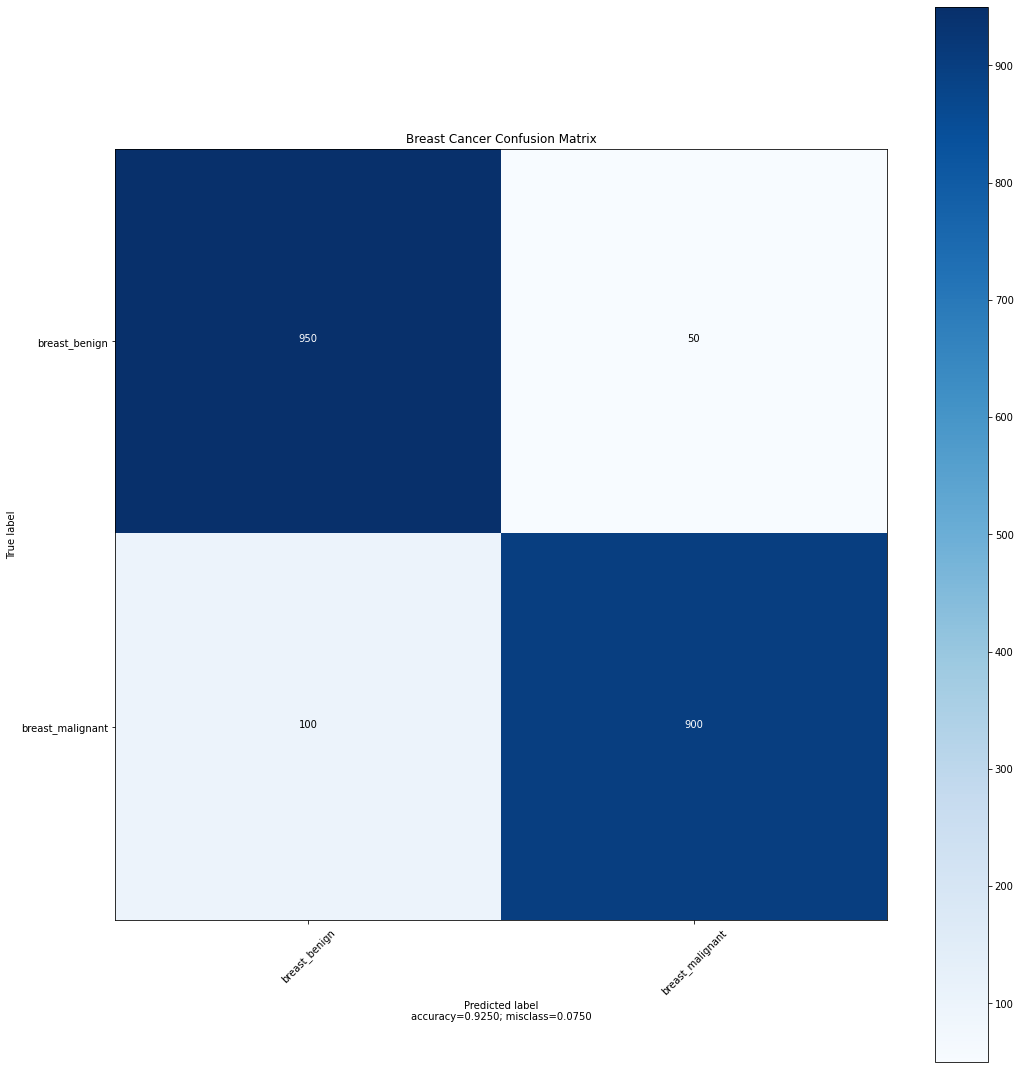

OSError: [Errno 22] Invalid argument: 'Breast Cancer Confusion Matrix.png'

<Figure size 432x288 with 0 Axes>

In [16]:
className = 'Breast Cancer '
cpath = os.path.join(mpath, 'Breast Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 20000 images belonging to 5 classes.

For Val :  Found 5000 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                

625/625 [==============================] - 94s 147ms/step - loss: 195.2094 - accuracy: 0.7664 - val_loss: 108.9910 - val_accuracy: 0.8082

Epoch 00001: val_loss improved from inf to 108.99096, saving model to Lung and Colon Cancer ResNet50V2.h5


C:\Users\alexj\anaconda3\envs\compvis\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
625/625 [==============================] - 75s 119ms/step - loss: 105.1472 - accuracy: 0.8387 - val_loss: 110.1879 - val_accuracy: 0.8562

Epoch 00002: val_loss did not improve from 108.99096
Epoch 3/20
625/625 [==============================] - 75s 121ms/step - loss: 121.2321 - accuracy: 0.8497 - val_loss: 461.9724 - val_accuracy: 0.7090

Epoch 00003: val_loss did not improve from 108.99096
Epoch 4/20
625/625 [==============================] - 75s 120ms/step - loss: 100.6186 - accuracy: 0.8730 - val_loss: 158.0120 - val_accuracy: 0.8228

Epoch 00004: val_loss did not improve from 108.99096
Epoch 5/20
625/625 [==============================] - 75s 119ms/step - loss: 101.4693 - accuracy: 0.8784 - val_loss: 112.7091 - val_accuracy: 0.8716

Epoch 00005: val_loss did not improve from 108.99096
Epoch 6/20
625/625 [==============================] - 74s 119ms/step - loss: 96.4194 - accuracy: 0.8888 - val_loss: 114.6514 - val_accuracy: 0.8770

Epoch 00006: val_loss did not improve f

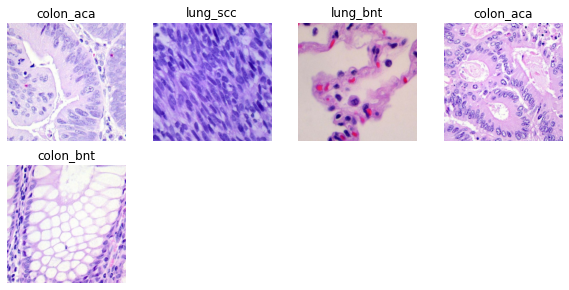

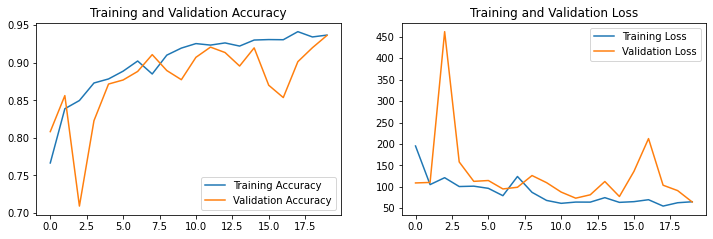

157/157 [==============================] - 15s 96ms/step - loss: 64.5117 - accuracy: 0.9364
Accuracy on the Test Set = 93.64 %
Model Saved!
True :  [0 0 0 ... 4 4 4]
Predicted :  [0 1 0 ... 4 4 4]


<Figure size 432x288 with 0 Axes>

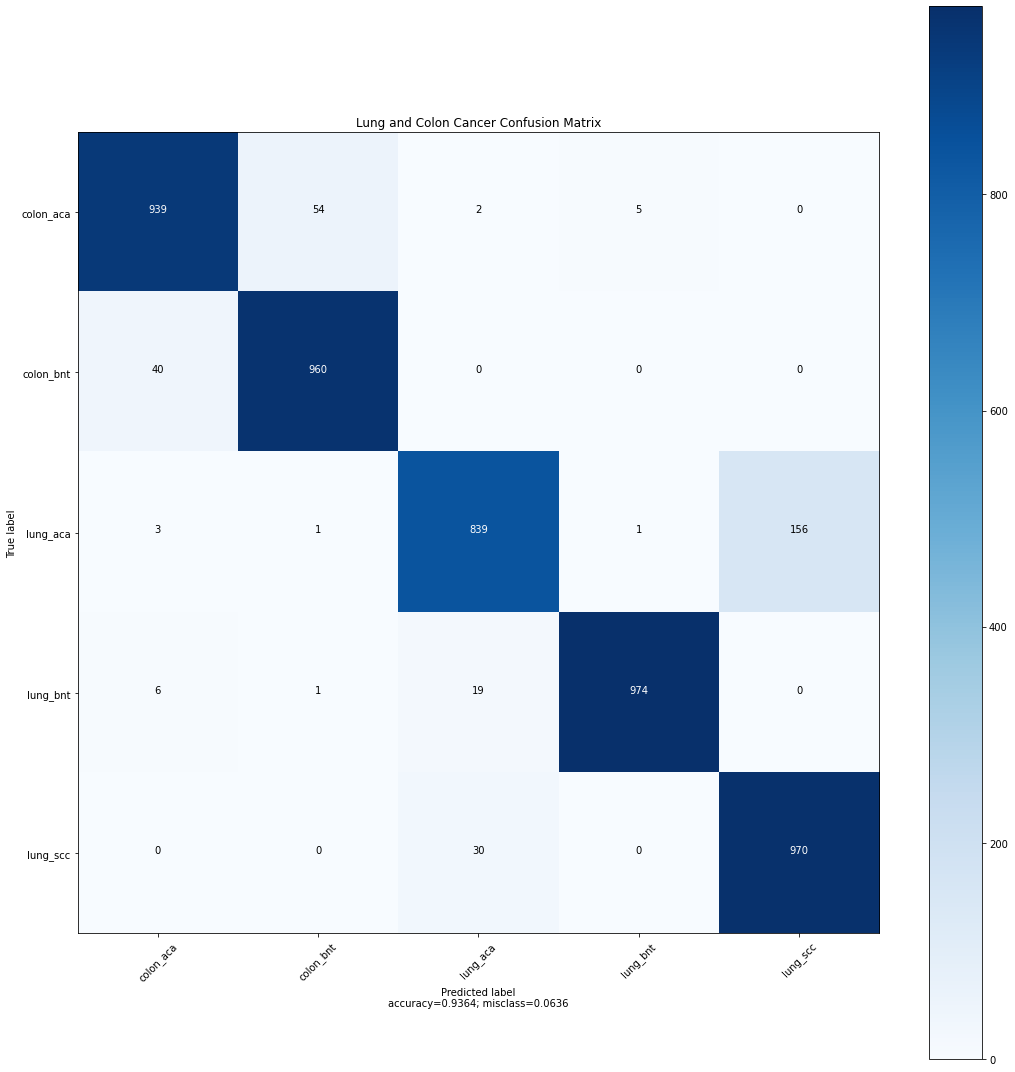

<Figure size 432x288 with 0 Axes>

In [17]:
className = 'Lung and Colon Cancer '
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)